In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/common/users/qs72/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
#!pip install --user tensorflow-gpu
# !pip install --user altair

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import tensorflow as tf
import sklearn.model_selection as sk
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [4]:
print(tf.__version__)
tf.config.experimental.list_physical_devices('GPU')

2.0.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Read the CSV and give it a scan


In [5]:
t = pd.read_csv('/common/users/qs72/all_data_info.csv')
# t_1  = t[t["new_filename"].str.startswith('1')]
t_1 = t

/koko/system/anaconda/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
t_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102562 entries, 0 to 102561
Data columns (total 12 columns):
artist          102562 non-null object
date            76398 non-null object
genre           101320 non-null object
pixelsx         102562 non-null object
pixelsy         102562 non-null object
size_bytes      102561 non-null object
source          102395 non-null object
style           101580 non-null object
title           102440 non-null object
artist_group    102561 non-null object
in_train        102558 non-null object
new_filename    101381 non-null object
dtypes: object(12)
memory usage: 9.4+ MB


# Data Cleaning
We can see that most of the data are non-null which makes this dataset relativly good for the study. But there are still some problems here, but first let's take only the data we want and may related to our study. Out study is about find if there are realtion between genre and age they produced. Further more, we may want to build a machine learning classification that could gives the genre of the painting according to the painting image uploaded. So here what we want date,genre, and new_filename. The other problem here is date is stored as object, which we would like transfer it into integer.

In [7]:
t_1["date"]=pd.to_numeric(t_1["date"],errors='coerce')
t_1 = t_1[["new_filename","genre","date"]].dropna()
t_1["date"] = t_1["date"].astype(int)
t_1

new_filename                     genre  date
0        102257.jpg                  abstract  1955
1         75232.jpg                  abstract  1950
7         49823.jpg  bird-and-flower painting  1838
8         63861.jpg                  abstract  1963
10        53180.jpg  bird-and-flower painting  1844
...             ...                       ...   ...
102553    36690.jpg                  abstract  1957
102555    11921.jpg           animal painting  1954
102557    25525.jpg                  abstract  1948
102560     9021.jpg                    marina  1982
102561    36564.jpg                 landscape  1913

[65975 rows x 3 columns]

In [8]:
t_1.nunique()

new_filename    65974
genre              41
date              638
dtype: int64

In [9]:
# Run this cell for Corrupting jepg
#for filename in filenames:
#     try:
#         filecontents = tf.io.read_file(filename)
#         image = tf.image.decode_jpeg(filecontents, channels = 3)
#         print(filename)
#         # tf.compat.v1.Print(image,[filename]) 
#     except Exception as e:
#         print("corrupt: "+filename)

# Descriptive Statistics

In [10]:
t_1["genre"].describe()

count        65975
unique          41
top       portrait
freq         11025
Name: genre, dtype: object

In [11]:
t_1["date"].describe()

count    65975.000000
mean      1874.828602
std        118.467190
min        187.000000
25%       1872.000000
50%       1907.000000
75%       1938.000000
max       2012.000000
Name: date, dtype: float64

In [12]:
temp = t_1["genre"].value_counts()
temp

portrait                    11025
landscape                    9909
genre painting               9217
abstract                     7903
religious painting           4328
cityscape                    3175
still life                   2280
sketch and study             1873
figurative                   1670
illustration                 1598
symbolic painting            1566
nude painting (nu)           1397
design                       1142
self-portrait                1134
marina                       1105
mythological painting        1053
flower painting              1012
animal painting               917
allegorical painting          659
history painting              598
interior                      451
literary painting             390
poster                        220
battle painting               193
capriccio                     165
tessellation                  153
cloudscape                    134
caricature                    126
wildlife painting             108
veduta        

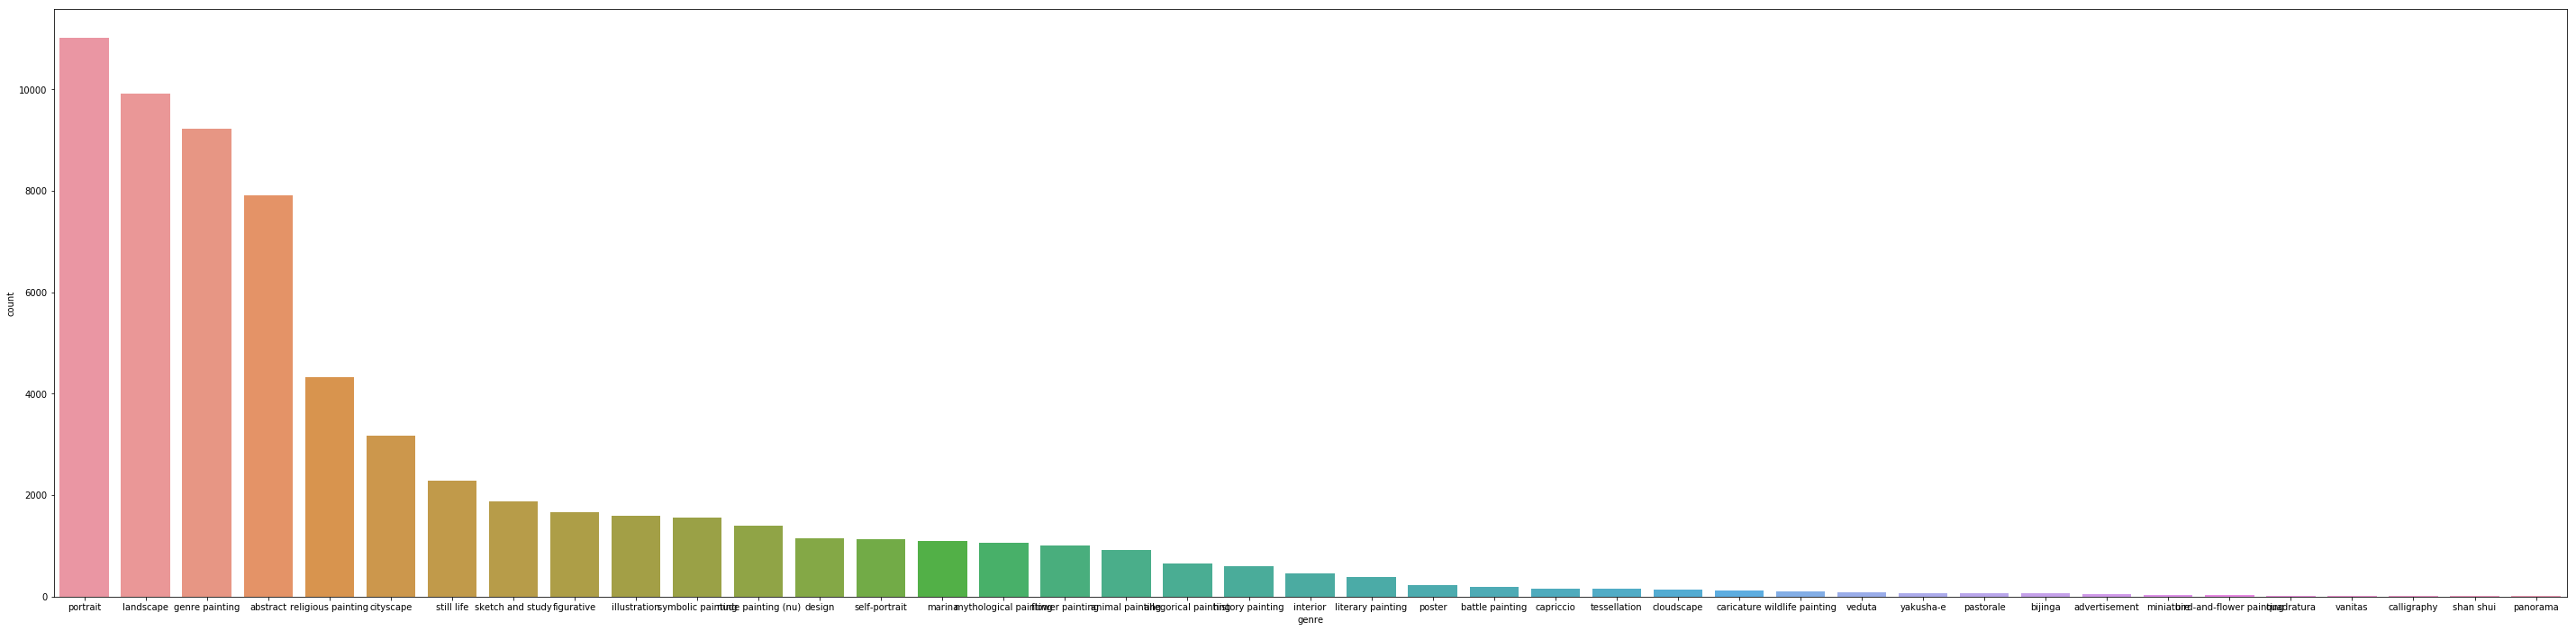

In [13]:
plt.figure(figsize=(50,12))
graph = sns.countplot(x = "genre" ,data =t_1, order=temp.index)

Ok, now, we have 41 types of genre which is basiclly too much for us, and a lot of them may only have few entries among the data set, so we want only the major cases.

In [14]:

temp = t_1["genre"].value_counts()
temp_1 = temp.nlargest(5).keys()
temp_2 = temp.nlargest(2).keys()
t_2 = t_1
t_1 = t_1[t_1["genre"].isin(temp_1)]
t_2 = t_2[t_2["genre"].isin(temp_2)]

t_1

new_filename           genre  date
0        102257.jpg        abstract  1955
1         75232.jpg        abstract  1950
8         63861.jpg        abstract  1963
11        70944.jpg       landscape  1937
15        32996.jpg  genre painting  1890
...             ...             ...   ...
102547    94016.jpg        abstract  1981
102550     9400.jpg        abstract  1978
102553    36690.jpg        abstract  1957
102557    25525.jpg        abstract  1948
102561    36564.jpg       landscape  1913

[42382 rows x 3 columns]

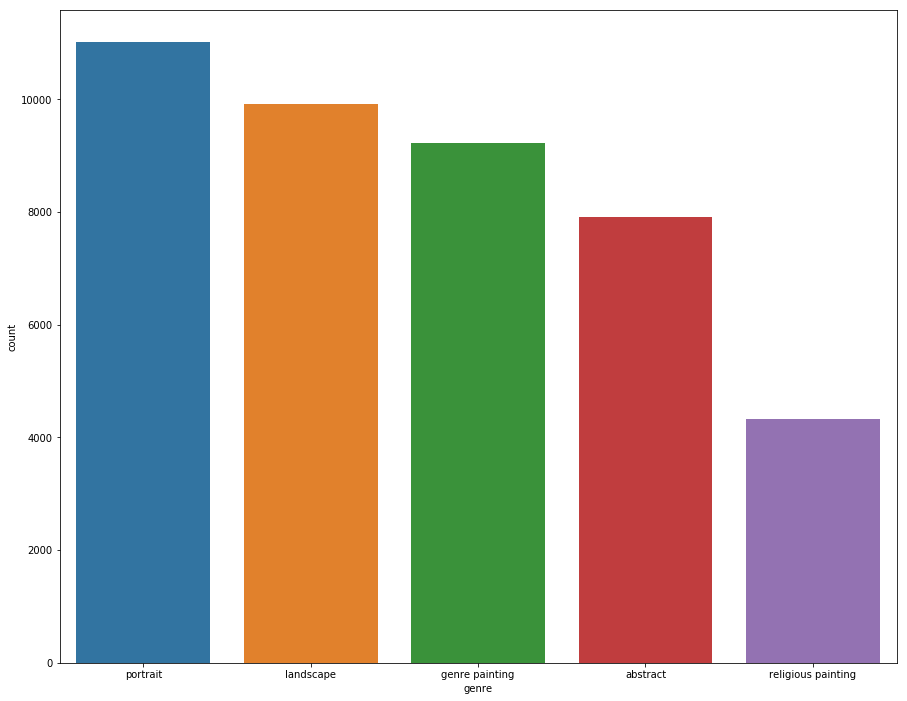

In [15]:
plt.figure(figsize=(15,12))
graph = sns.countplot(x = "genre" ,data =t_1, order=temp_1)

In [16]:
t_1

new_filename           genre  date
0        102257.jpg        abstract  1955
1         75232.jpg        abstract  1950
8         63861.jpg        abstract  1963
11        70944.jpg       landscape  1937
15        32996.jpg  genre painting  1890
...             ...             ...   ...
102547    94016.jpg        abstract  1981
102550     9400.jpg        abstract  1978
102553    36690.jpg        abstract  1957
102557    25525.jpg        abstract  1948
102561    36564.jpg       landscape  1913

[42382 rows x 3 columns]

In [17]:
label_type_1 = pd.unique(t_1["genre"])
label_type_2 = pd.unique(t_2["genre"])

label_type_1

array(['abstract', 'landscape', 'genre painting', 'religious painting',
       'portrait'], dtype=object)

In [18]:
label_type_1[0]

'abstract'

In [19]:
t_1["genre"].describe()

count        42382
unique           5
top       portrait
freq         11025
Name: genre, dtype: object

In [20]:
t_1["date"].describe()

count    42382.000000
mean      1865.671629
std        129.522179
min       1059.000000
25%       1865.000000
50%       1902.000000
75%       1939.000000
max       2012.000000
Name: date, dtype: float64

In [21]:
t_1["date"].mode()

0    1910
dtype: int64

In [22]:
data = t_1[["date","genre"]]
data["date"] = data["date"].astype(str) +"-01-01"
data

/koko/system/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


date           genre
0       1955-01-01        abstract
1       1950-01-01        abstract
8       1963-01-01        abstract
11      1937-01-01       landscape
15      1890-01-01  genre painting
...            ...             ...
102547  1981-01-01        abstract
102550  1978-01-01        abstract
102553  1957-01-01        abstract
102557  1948-01-01        abstract
102561  1913-01-01       landscape

[42382 rows x 2 columns]

In [23]:
alt.data_transformers.disable_max_rows()
alt.Chart(data).mark_bar().encode(
    x="date:T",
    y="count():Q",
    color='genre',
).properties(
    width=900,
    height = 600
)

alt.Chart(...)

In [24]:
alt.Chart(data).mark_point().encode(
    x="date:T",
    y="count():Q",
    color='genre',
).properties(
    width=900,
    height = 600
)

alt.Chart(...)

## put date into categories

In [25]:
t_1["date"] = t_1["date"]//100
t_1

/koko/system/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


new_filename           genre  date
0        102257.jpg        abstract    19
1         75232.jpg        abstract    19
8         63861.jpg        abstract    19
11        70944.jpg       landscape    19
15        32996.jpg  genre painting    18
...             ...             ...   ...
102547    94016.jpg        abstract    19
102550     9400.jpg        abstract    19
102553    36690.jpg        abstract    19
102557    25525.jpg        abstract    19
102561    36564.jpg       landscape    19

[42382 rows x 3 columns]

In [26]:
alt.data_transformers.disable_max_rows()
alt.Chart(t_1).mark_bar().encode(
    x="date:O",
    y="count():Q",
    color='genre',
).properties(
    width=900,
    height = 600
)

alt.Chart(...)

# Machine Learning
Reference:<br>
Tensorflow Tutorials:<br>
https://www.tensorflow.org/tutorials/load_data/images#%E4%BC%A0%E9%80%92%E6%95%B0%E6%8D%AE%E9%9B%86%E8%87%B3%E6%A8%A1%E5%9E%8B<br>
https://www.tensorflow.org/tutorials/images/classification<br>
https://www.tensorflow.org/tutorials/keras/classification<br>







In [27]:
label_to_index = dict((name, index) for index, name in enumerate(label_type_1))
label_to_index

{'abstract': 0,
 'landscape': 1,
 'genre painting': 2,
 'religious painting': 3,
 'portrait': 4}

In [28]:
filenames = ('/common/users/qs72/image/'+t_1["new_filename"]).tolist()
labels = t_1["genre"].tolist()

In [29]:
index_label = [label_to_index[label] for label in labels]

In [30]:
path_train, path_test, label_train, label_test = sk.train_test_split(filenames, index_label, test_size=0.1)

path_train, path_val, label_train, label_val = sk.train_test_split(path_train, label_train, test_size=0.2)

In [31]:
IMAGE_SIZE = 64
ds_size = len(label_train)

In [32]:
def load(filename):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0
  return image

pretest = tf.data.Dataset.from_tensor_slices(path_test)

In [33]:
pretrain = tf.data.Dataset.from_tensor_slices((path_train, label_train))
preval = tf.data.Dataset.from_tensor_slices((path_val, label_val))
    
def load_and_preprocess(filename, label):
  return load(filename), label


train = pretrain.map(load_and_preprocess)
val = preval.map(load_and_preprocess)
test = pretest.map(load)

Set a large batch_size inoder to accelerate the entire process

In [34]:
BATCH_SIZE = 256


ds = train.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=ds_size))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
val = val.batch(BATCH_SIZE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.batch(BATCH_SIZE)
test = test.prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


## model design
After a few failed and unsucessful tries, I found this vgg-like model did its job, the filter size for the Conv layers was chosesn to be 8, since, I don't want it to stick to local.
<br>
Reference:
<br>https://towardsdatascience.com/vgg-neural-networks-the-next-step-after-alexnet-3f91fa9ffe2c
<br>https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
<br>https://neurohive.io/en/popular-networks/vgg16/

In [35]:

model = keras.Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMAGE_SIZE, IMAGE_SIZE ,3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='valid', activation='relu'),
    Conv2D(64, 3, padding='valid', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5,activation = 'softmax')
])

In [36]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [37]:
steps=tf.math.ceil(ds_size/BATCH_SIZE).numpy()
steps

120.0

In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(ds, epochs=10000,validation_data = val, steps_per_epoch=steps,callbacks = [early_stop])

Train for 120.0 steps, validate for 30 steps
Epoch 1/10000
120/120 [==============================] - 2201s 18s/step - loss: 1.2430 - accuracy: 0.4939 - val_loss: 1.0932 - val_accuracy: 0.5630
Epoch 2/10000
120/120 [==============================] - 573s 5s/step - loss: 1.0287 - accuracy: 0.5932 - val_loss: 0.9965 - val_accuracy: 0.6124
Epoch 3/10000
120/120 [==============================] - 521s 4s/step - loss: 0.9461 - accuracy: 0.6316 - val_loss: 0.9637 - val_accuracy: 0.6260
Epoch 4/10000
120/120 [==============================] - 489s 4s/step - loss: 0.8713 - accuracy: 0.6608 - val_loss: 0.9349 - val_accuracy: 0.6361
Epoch 5/10000
120/120 [==============================] - 541s 5s/step - loss: 0.7989 - accuracy: 0.6914 - val_loss: 0.9414 - val_accuracy: 0.6331
Epoch 6/10000
120/120 [==============================] - 2031s 17s/step - loss: 0.7047 - accuracy: 0.7305 - val_loss: 0.9515 - val_accuracy: 0.6347
Epoch 7/10000
120/120 [==============================] - 2071s 17s/step - l

In [39]:
def plot_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(history.history['accuracy']))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

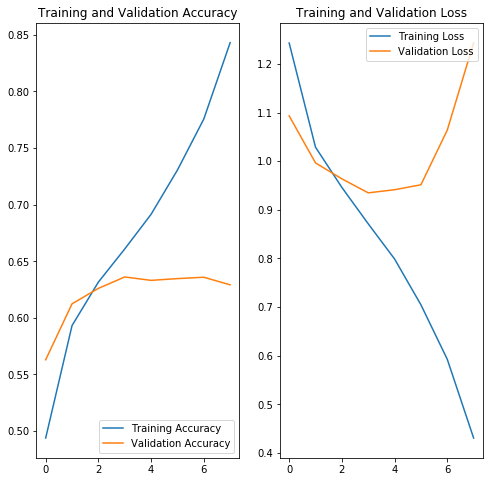

In [40]:
 
plot_model(history)

In [41]:
model.save('5class_modelvgg_3')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 5class_modelvgg_3/assets


As we can see, the train accuracy goes significantly larger than the validation one, so it might be overfiting. We may need to make some drop out.

In [42]:
model = keras.Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMAGE_SIZE, IMAGE_SIZE ,3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='valid', activation='relu'),
    Conv2D(64, 3, padding='valid', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5,activation = 'softmax')
    
])

In [43]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [44]:
history = model.fit(ds, epochs=10000,validation_data = val, steps_per_epoch=steps,callbacks = [early_stop])

Train for 120.0 steps, validate for 30 steps
Epoch 1/10000
120/120 [==============================] - 4766s 40s/step - loss: 1.2029 - accuracy: 0.5110 - val_loss: 1.0442 - val_accuracy: 0.5875
Epoch 2/10000
120/120 [==============================] - 1519s 13s/step - loss: 1.0268 - accuracy: 0.5924 - val_loss: 0.9786 - val_accuracy: 0.6162
Epoch 3/10000
120/120 [==============================] - 2411s 20s/step - loss: 0.9396 - accuracy: 0.6310 - val_loss: 0.9409 - val_accuracy: 0.6271
Epoch 4/10000
120/120 [==============================] - 2038s 17s/step - loss: 0.8786 - accuracy: 0.6574 - val_loss: 0.9199 - val_accuracy: 0.6390
Epoch 5/10000
120/120 [==============================] - 1587s 13s/step - loss: 0.8133 - accuracy: 0.6848 - val_loss: 0.9008 - val_accuracy: 0.6490
Epoch 6/10000
120/120 [==============================] - 1332s 11s/step - loss: 0.7438 - accuracy: 0.7139 - val_loss: 0.9246 - val_accuracy: 0.6429
Epoch 7/10000
120/120 [==============================] - 1219s 10s/

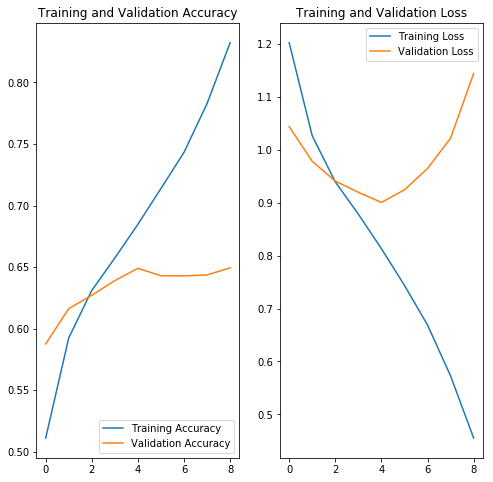

In [45]:
plot_model(history)

In [46]:
model.save('5class_modelvgg_3_droupout')

INFO:tensorflow:Assets written to: 5class_modelvgg_3_droupout/assets


The problem seems not happened because overfitting then, let's create a confusion matrix to have a look with out test set

In [47]:
predictions = model.predict(test)

In [48]:
pred = []
for x in predictions:
    pred.append(np.argmax(x))

In [49]:
confusion = tf.math.confusion_matrix(labels=label_test, predictions=pred)
print(confusion)

tf.Tensor(
[[558  68  94  12  42]
 [ 47 744 141  16  26]
 [ 75 196 462  83 141]
 [ 21  32 139 160  74]
 [ 43  38 153  49 825]], shape=(5, 5), dtype=int32)


So the genre painting and religious painting are the most confusion one. And I think it is reasonable, since even for human beings it is hard to tell if is a religious painting/ genre painting or not.

In [56]:
label_to_index = dict((name, index) for index, name in enumerate(label_type_2))
label_to_index

{'landscape': 0, 'portrait': 1}

In [57]:
filenames = ('/common/users/qs72/image/'+t_2["new_filename"]).tolist()
labels = t_2["genre"].tolist()

In [58]:
index_label = [label_to_index[label] for label in labels]

In [59]:
path_train, path_test, label_train, label_test = sk.train_test_split(filenames, index_label, test_size=0.1)

path_train, path_val, label_train, label_val = sk.train_test_split(path_train, label_train, test_size=0.2)

In [60]:
IMAGE_SIZE = 64
ds_size = len(label_train)

In [61]:
pretest = tf.data.Dataset.from_tensor_slices(path_test)
pretrain = tf.data.Dataset.from_tensor_slices((path_train, label_train))
preval = tf.data.Dataset.from_tensor_slices((path_val, label_val))
train = pretrain.map(load_and_preprocess)
val = preval.map(load_and_preprocess)

In [62]:
test = pretest.map(load)

In [63]:
BATCH_SIZE = 128


ds = train.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=ds_size))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
val = val.batch(BATCH_SIZE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.batch(BATCH_SIZE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [80]:

model = keras.Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMAGE_SIZE, IMAGE_SIZE ,3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='valid', activation='relu'),
    Conv2D(64, 3, padding='valid', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1,activation = 'sigmoid')#The only change here, change the activation function to sigmoid, so it works for binary classifacation 
])

In [81]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #make loss function binary, since used sigmoid, set from_logits to False
              metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12544)            

In [82]:
steps=tf.math.ceil(ds_size/BATCH_SIZE).numpy()
steps

118.0

In [83]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(ds, epochs=10000,validation_data = val, steps_per_epoch=steps,callbacks = [early_stop])

Train for 118.0 steps, validate for 30 steps
Epoch 1/10000
118/118 [==============================] - 450s 4s/step - loss: 0.3992 - accuracy: 0.8149 - val_loss: 0.2633 - val_accuracy: 0.8891
Epoch 2/10000
118/118 [==============================] - 266s 2s/step - loss: 0.2823 - accuracy: 0.8810 - val_loss: 0.2506 - val_accuracy: 0.8960
Epoch 3/10000
118/118 [==============================] - 191s 2s/step - loss: 0.2307 - accuracy: 0.9043 - val_loss: 0.2278 - val_accuracy: 0.9005
Epoch 4/10000
118/118 [==============================] - 373s 3s/step - loss: 0.2108 - accuracy: 0.9103 - val_loss: 0.2113 - val_accuracy: 0.9148
Epoch 5/10000
118/118 [==============================] - 269s 2s/step - loss: 0.1940 - accuracy: 0.9198 - val_loss: 0.2620 - val_accuracy: 0.8923
Epoch 6/10000
118/118 [==============================] - 179s 2s/step - loss: 0.1769 - accuracy: 0.9268 - val_loss: 0.2191 - val_accuracy: 0.9124
Epoch 7/10000
118/118 [==============================] - 716s 6s/step - loss: 0

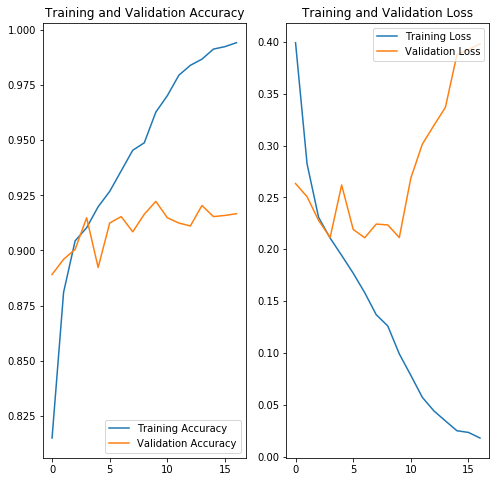

In [84]:
plot_model(history)

In [ ]:
model.save('2class_modelvgg_3_droupout')